In [4]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.cluster import KMeans
from pykalman import KalmanFilter 
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt          
%matplotlib inline
import itertools
from collections import OrderedDict
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import sys
import errno

In [5]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv (open/high/low/close/volume) data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [6]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
#one day in seconds
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['volume']
df['logVolume'] = df['volume'].apply(np.log)

In [7]:
def fitKCA(t,z,q,fwd=0):
    """
        Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
        Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    """
    #1) Set up matrices A,H and a seed for Q
    h = (t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
               [0,1,h],
               [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2)Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf = kf.em(z)
    #4) Smooth
    x_mean,x_covar = kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
                                          filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1) 
    for i in range(1,x_covar.shape[1]): 
        x_std_=x_covar[:,i,i]**.5 
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1) 
    return x_mean,x_std,x_covar

In [8]:
# by MLdP on 02/20/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis of a periodic function
import matplotlib.pyplot as pp
mainPath=''
#---------------------------------------------------------
def vsFFT(t,z):
    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=.001)[:2]
    #4) Plot KCA's point estimates
    color=['b','g','r']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', color=color[0])
    pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', color=color[1])
    pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', color=color[2])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    pp.clf();pp.close() # reset pylab
    return

In [9]:
def v_a(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    x_mean,x_std,x_covar=fitKCA(df.date.values, df.y.values, .1) 
    
    df['velocity'] = x_mean[:,1]
    df['acceleration'] = x_mean[:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)
    
    p_df = df[['ds', 'velocity', 'acceleration']].copy()

    p_df['y'] = p_df['velocity']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

    p_df['y'] = p_df['acceleration']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

count      631.000000
mean         0.402389
std       3936.966475
min     -12009.914622
25%      -1275.684817
50%          5.607567
75%       1258.665784
max      12265.593964
Name: velocity, dtype: float64
count    631.000000
mean       0.000034
std        0.091025
min       -0.276183
25%       -0.028473
50%        0.000745
75%        0.028971
max        0.279451
Name: acceleration, dtype: float64


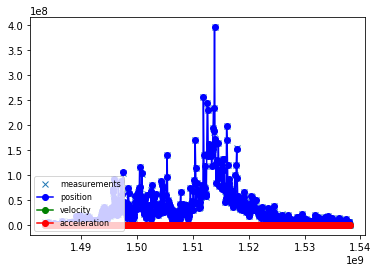

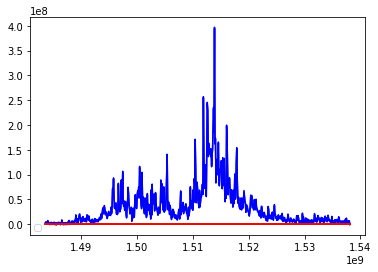

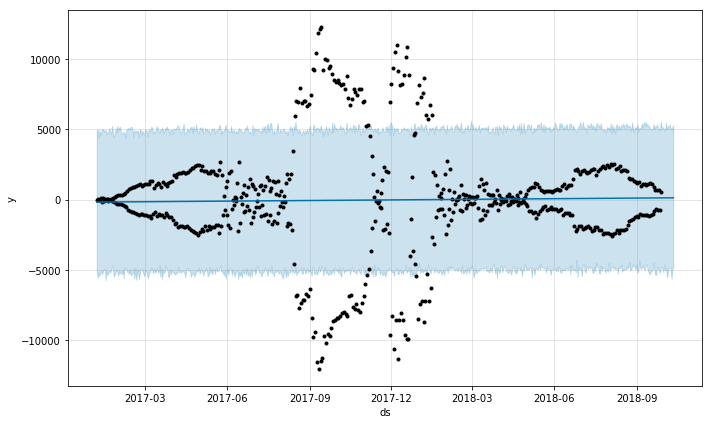

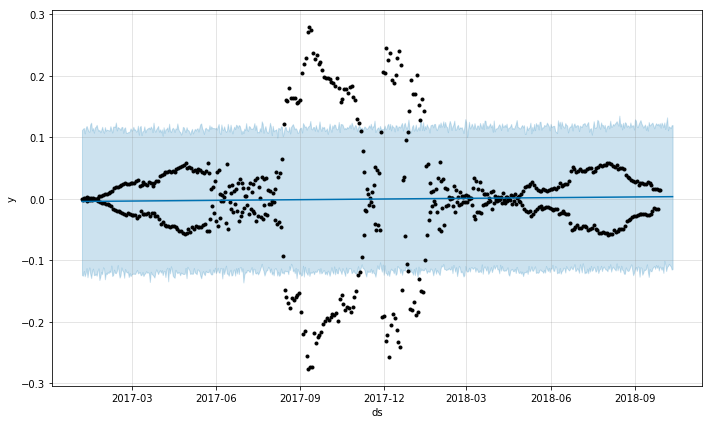

In [10]:
v_a(df)

In [11]:
x_mean,x_std,x_covar=fitKCA(df.date.values,df.y.values,1)

In [12]:
# Mean Acceleration

In [13]:
print(x_mean[0,2])

0.0004239577577412496


In [14]:
# Std Acceleration

In [15]:
print(x_std[0,2])

2.3183688711590323e-05


In [16]:
# Mean Velocity/Inertia

In [17]:
print(x_mean[0,1])

0.10789080692978215


In [18]:
# Std Velocity/Inertia

In [19]:
print(x_std[0,1])

0.9999490117909443


## Figure 1: KCA estimated mean states

Text(0.5,1,'Measurements: Volumes')

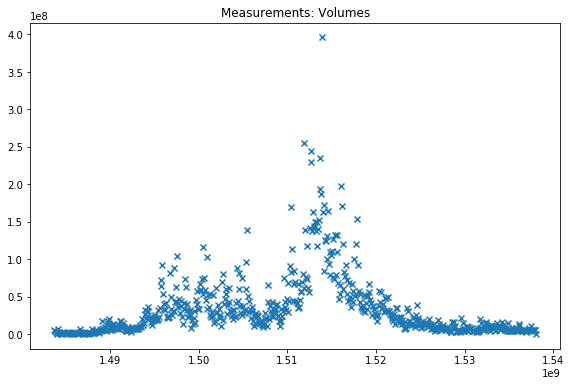

In [30]:
#measurements
plt.scatter(df.date, df.volume, marker='x')
plt.title('Measurements: Volumes')

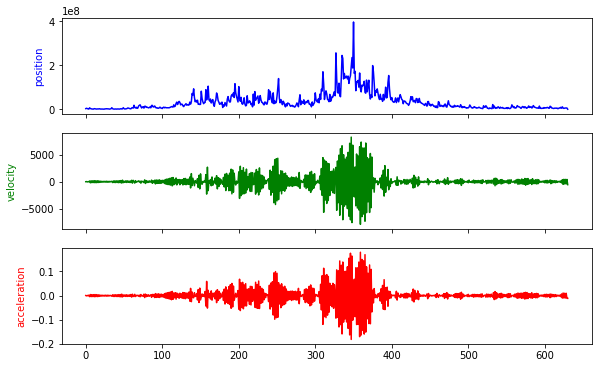

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=False, sharex='all')
ax1.plot(x_mean[:,0],color='b')
ax1.set_ylabel('position',color='b')
ax2.plot(x_mean[:,1],color='g')
ax2.set_ylabel('velocity',color='g')
ax3.plot(x_mean[:,2],color='r')
ax3.set_ylabel('acceleration',color='r')
plt.show()

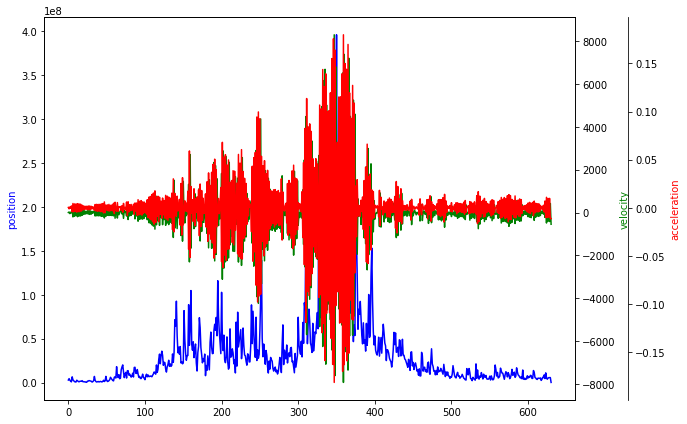

In [32]:
# To make things reproducible...
np.random.seed(1977)

#fig, ax = plt.subplots()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
fig.subplots_adjust(right=0.75)
ax3.spines['right'].set_position(('axes', 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)

#position
ax1.set_ylabel('position',color='b')
ax1.plot(x_mean[:,0],color='b')
#velocity
ax2.set_ylabel('velocity',color='g')
ax2.plot(x_mean[:,1],color='g')
#acceleration
ax3.set_ylabel('acceleration',color='r')
ax3.plot(x_mean[:,2],color='r')

fig.tight_layout()
plt.show()

## Figure 2 (shows that FFT extracts a signal very similar to the first state component extracted by KCA) 

In [33]:
# Not sure how to display this better...zooming in still doesn't show detail as in the paper

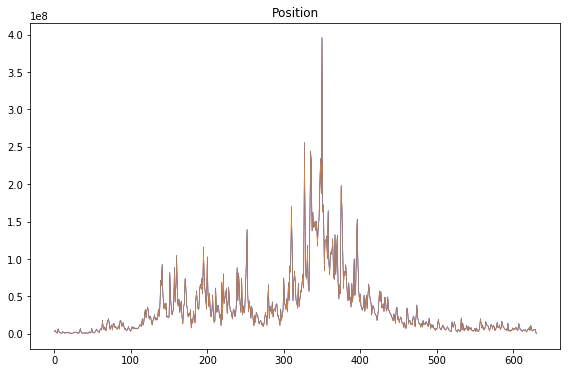

In [34]:
#mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [9.5,6] #width,height
#position
upper_error_bars = x_mean[:,0] + x_std[:,0]
lower_error_bars = x_mean[:,0] - x_std[:,0]
plt.plot(x_mean[:,0],color='blue',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)
plt.title('Position')
plt.show()

Text(0.5,1,'Velocity')

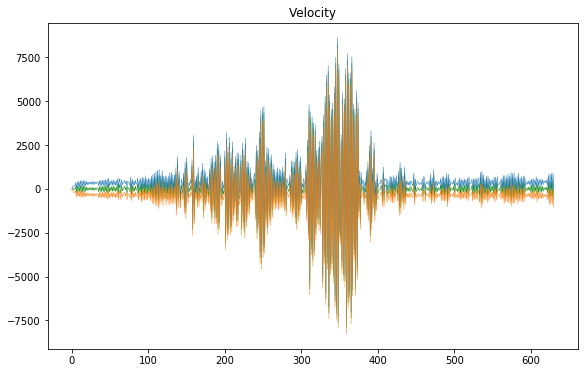

In [35]:
#velocity

upper_error_bars = x_mean[:,1] + x_std[:,1]
lower_error_bars = x_mean[:,1] - x_std[:,1]

plt.plot(x_mean[:,1],color='green',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Velocity')

Text(0.5,1,'Acceleration')

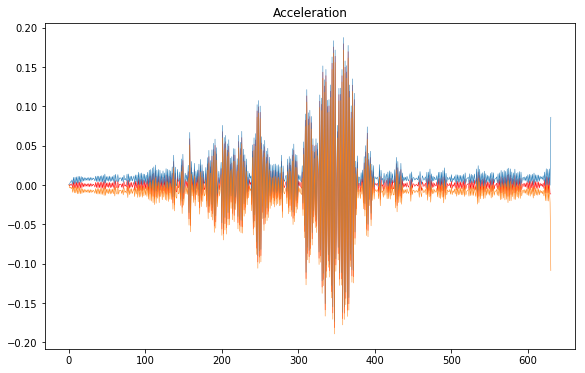

In [36]:
#acceleration

upper_error_bars = x_mean[:,2] + x_std[:,2]
lower_error_bars = x_mean[:,2] - x_std[:,2]

plt.plot(x_mean[:,2],color='red',linewidth=.5) 
plt.plot(upper_error_bars,linewidth=.5)
plt.plot(lower_error_bars,linewidth=.5)

plt.title('Acceleration')

## Estimated Position vs Volume

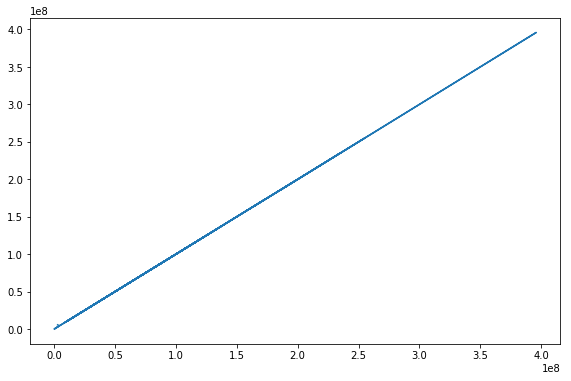

In [37]:
plt.plot(x_mean[:,0],df.volume)
#plt.plot(x_mean[:,0], color='b', linewidth=.45)
#plt.plot(df.weightedAverage, color='y',linewidth=.45)

In [38]:
# This linear relationship indicates that the estimated position and volume values were practically equal 
# after the beginning period.

## Monthly Subsets

In [ ]:
d = dict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items():
    print(i)
    v_a(df_month)